# Image Classification with a Multi-Layer Perceptron


The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 categories (0 to 9). The dataset we will use is the MNIST dataset, a classic dataset in the machine learning community, which has been around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. As you become a machine learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.


In [ ]:
# MNIST download doesn't work in torchvision<0.9.0
# Execute this code to solve it (https://github.com/pytorch/vision/issues/1938#issuecomment-594623431)
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
# Set the random seed 123 from numpy
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
import numpy as np
np.random.seed(123)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms


train_images and train_labels form the "training set", the data that the model will learn from. The model will then be tested on the "test set", test_images and test_labels. Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging from 0 to 9. There is a one-to-one correspondence between the images and the labels.

### Defining the Hyper-parameters

We now define the hyperparameters that are going to be used throughout the notebook
to define the network, the data `batch_size`, the training `learning_rate`, and others.

In [ ]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':10,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-4,
    'log_interval':100,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

# whenever we send something to the selected device (X.to(device)) we already use
# either CPU or CUDA (GPU). Importantly...
# The .to() operation is in-place for nn.Module's, so network.to(device) suffices
# The .to() operation is NOT in.place for tensors, so we must assign the result
# to some tensor, like: X = X.to(device)


### Defining the PyTorch Dataset and the DataLoader

The PyTorch Dataset (https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is an inheritable `class` that helps us defining what source of data do we have (image, audio, text, ...) and how to load it (overriding the `__getitem__` function). The MNIST dataset is easible accessible from it.

The PyTorch DataLoader (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is an iterator that provides batching and shuffling capabilities, among others.

In [ ]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'],
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'],
    shuffle=False)

In [ ]:
# We can retrieve a sample from the dataset by simply indexing it
img, label = mnist_trainset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(train_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print('The Batched tensors return a collection of {} grayscale images ({} channel, {} height pixels, {} width pixels)'.format(bimg.shape[0],
                                                                                                                              bimg.shape[1],
                                                                                                                              bimg.shape[2],
                                                                                                                              bimg.shape[3]))
print('In the case of the labels, we obtain {} batched integers, one per image'.format(blabel.shape[0]))

Img shape:  torch.Size([1, 28, 28])
Label:  5
Batch Img shape:  torch.Size([64, 1, 28, 28])
Batch Label shape:  torch.Size([64])
The Batched tensors return a collection of 64 grayscale images (1 channel, 28 height pixels, 28 width pixels)
In the case of the labels, we obtain 64 batched integers, one per image


And now let's look at the kind of images we are dealing with:


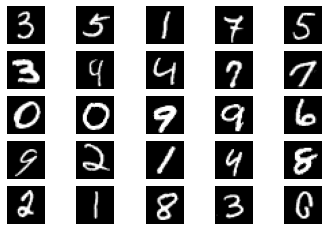

In [ ]:
import matplotlib.pyplot as plt
import random

# Definition of a Python function that plots a NxN grid of images contained
# in the images array
def plot_samples(images,N=5):

    '''
    Plots N**2 randomly selected images from training data in a NxN grid
    '''

    # Randomly select NxN images and save them in ps
    ps = random.sample(range(0,images.shape[0]), N**2)

    # Allocates figure f divided in subplots contained in an NxN axarr
    # https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.subplots.html
    f, axarr = plt.subplots(N, N)

    # Index for the images in ps to be plotted
    p = 0

    # Scan the NxN positions of the grid
    for i in range(N):
        for j in range(N):

            # Load the image pointed by p
            im = images[ps[p]]

            # If images are encoded in grayscale
            # (a tensor of 3 dimensions: width x height x luma)...
            if len(images.shape) == 3:
              # ...specify the colormap as grayscale
              # https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.imshow.html
              axarr[i,j].imshow(im,cmap='gray')
            else:
              # ...no need to specify any color map
              axarr[i,j].imshow(im)

            # Remove axis
            axarr[i,j].axis('off')

            # Point to the next image from the random selection
            p+=1
    # Show the plotted figure
    plt.show()

# convert the dataloader output tensors from the previous cell to numpy arrays
# The channel dimension has to be squeezed in order for matplotlib to work
# with grayscale images
img = bimg.squeeze(1).data.numpy()
plot_samples(img)

### BAAAAM, we've got some numbers there

# Training a Multi-Layer Perceptron (MLP)

Now that we have the dataset loaded and prepared, let's get some deep stuff spinning.

Our workflow will be as follow: first we will train our neural network with the training data, loaded from the constructed `train_loader`. The network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_loader` images, and we will verify if these predictions match the labels from `test_loader`.

### Exercise 1

For the time being, we will use a very simple network. It consists of a sequence of two `nn.Linear` layers, which are densely-connected (also called "fully-connected") neural layers. The last layer is a 10-way `nn.LogSoftmax` layer, which means it will return an array of 10 log-probability scores. Each score will be the probability that the current digit image belongs to one of our 10 digit classes. Please fill in the network definition below.

In [ ]:
# TODO: Define a variable 'network' by instantiating a PyTorch sequential model
# https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential
# Add a (1) nn.Linear hidden layer with 128 neurons, (2) a nn.ReLU,
# (3) the output nn.Linear and (4) the output nn.LogSoftmax
# NOTE: Consider the 'num_inputs', 'hidden_size', and 'num_classes' parameters
# defined above as hyper-params
import torch.nn as nn


def new_net(hidden_size, num_inputs, num_classes):
    return nn.Sequential(
      nn.Linear(num_inputs, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, num_classes),
      nn.LogSoftmax(dim=1)
    )

network = new_net(hparams['hidden_size'],hparams['num_inputs'],hparams['num_classes'])
network.to(hparams['device'])

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
  (3): LogSoftmax(dim=1)
)

Now we can check which is the architecture of the network, and the number of parameters of each layer with the following helper function:

In [ ]:
def get_nn_nparams(net):
  """ https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6 """
  pp=0
  for p in list(net.parameters()):
      nn=1
      for s in list(p.size()):
          nn = nn*s
      pp += nn
  return pp

print(network)
print('Num params: ', get_nn_nparams(network))

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
  (3): LogSoftmax(dim=1)
)
Num params:  101770


### Exercise 2

To make our network ready for training, we need to pick three more things:

*    **A loss function**: this is how the network will be able to measure how good a job works on its training data, and thus how it will be able to steer itself in the right direction. **Check the [PyTorch documentation](https://pytorch.org/docs/stable/nn.functional.html#nll-loss) for the negative log likelihood loss for multi-class classification from the functional API.**
*   **An optimizer**: this is the mechanism through which the network will update itself based on the data it sees and its loss function. **Check the [PyTorch documentation](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop) and find the RMSprop optimizer to use it.**
*   **Metrics to monitor during training and testing**. Here we will only care about accuracy (the fraction of the images that were correctly classified). **Define the accuracy function to return, for a batch, the count of correct predictions (hence same prediction as the label).**




In [ ]:
# Import optmizer
# https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop
import torch.optim as optim

# Import a functional API for the loss function (use this one !!)
# https://pytorch.org/docs/stable/nn.functional.html#nll-loss
import torch.nn.functional as F

# TODO: Specify the loss function. Don't call it, just assign it to 'criterion'
criterion = F.nll_loss

# TODO: Create the optimizer
optimizer = optim.RMSprop(network.parameters())

# Define the Accuracy metric in the function below by:
  # (1) obtain the maximum for each predicted element in the batch to get the class (it is the maximum index of the num_classes array per batch sample) (look at torch.argmax in the PyTorch documentation)
  # (2) compare the predicted class index with the index in its corresponding neighbor within label_batch
  # (3) sum up the number of affirmative comparisons and return the summation
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum


### Exercise 3

Next, the training and test functions that iterate for an epoch are defined. We will need to adapt that `data` tensors, which include images, so that their shape is compatible with the fully connected input of size `num_inputs` of the network. We will use `view()` to flatten the 2D images into 1D vectors.

In [ ]:
def train_epoch(train_loader, network, optimizer, criterion, hparams):

  # Activate the train=True flag inside the model
  network.train()

  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()

      # TODO

      data = data.view(data.shape[0],hparams['num_inputs'])

      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

In [ ]:
def test_epoch(test_loader, network, hparams):

    # Dectivate the train=True flag inside the model
    network.eval()

    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:

            # Load data and feed it through the neural network
            data, target = data.to(device), target.to(device)

            # TODO
            data = data.view(data.shape[0],hparams['num_inputs'])

            output = network(data)

            # Apply the loss criterion and accumulate the loss
            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss

            # WARNING: If you are using older Torch versions, the previous call may need to be replaced by
            # test_loss += criterion(output, target, size_average=False).item()

            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)

    # Average accuracy across all correct predictions batches now
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

### Exercise 4

Now that the `network` and the training and test functions are good to go epoch by epoch, build the loop to make as many as `hparams['num_epochs']` epochs by alternating the train and test phases. Check what these functions return and store the resulting values in lists that will be used to plot the results in the later cell.

In [ ]:
# Init lists to save the evolution of the training & test losses/accuracy.
train_losses = []
test_losses = []
test_accs = []

# For each epoch
for epoch in range(1, hparams['num_epochs'] + 1):

  # Compute & save the average training loss for the current epoch
  train_loss = train_epoch(train_loader, network, optimizer, criterion, hparams)
  train_losses.append(train_loss)

  # TODO: Compute & save the average test loss & accuracy for the current epoch
  # HELP: Review the functions previously defined to implement the train/test epochs
  test_loss, test_accuracy = test_epoch(test_loader, network, hparams)
  test_losses.append(test_loss)
  test_accs.append(test_accuracy)

  test_losses.append(test_loss)
  test_accs.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334902
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.430277
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.251842
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.119186
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.243972
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.332917
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.634645
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.263169
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.166461
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.415159

Test set: Average loss: 0.2182, Accuracy: 9402/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.288960
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.235281
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.211953
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.236620
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.139471
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.626432
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.489160
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.165560
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.381557
T

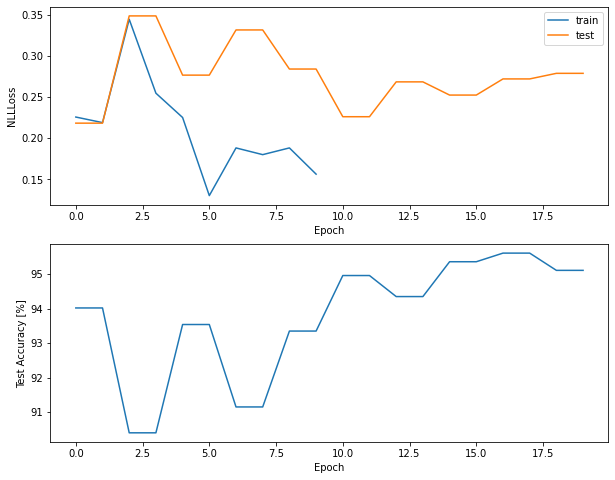

In [ ]:
# Plot the plots of the learning curves
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(test_accs)

#### References

[1] https://github.com/pytorch/examples/blob/master/mnist/main.py